In [1]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method 
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.torch.attacks.noise import noise 
from cleverhans.torch.attacks.hop_skip_jump_attack import hop_skip_jump_attack 
from cleverhans.torch.attacks.spsa import spsa 
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2 
from cleverhans.torch.attacks.sparse_l1_descent import sparse_l1_descent 


In [2]:
from models import *
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
#from frozendict import frozendict
from datetime import datetime
import seaborn as sn
import pandas as pd


from absl import app, flags
from easydict import EasyDict
import torch.nn as nn

%matplotlib inline

import seaborn as sns

from custom_transform import *
from transforms import TRANSFORMS
from mask import *
import imageio
from utils import generate_gif
import os


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
   
  
])


epochs = 10
batch_size = 1000
test_batch_size = 10000
stable_batch_size = 60000

use_cuda = torch.cuda.is_available()
print(use_cuda)

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}

test_kwargs = {'batch_size': test_batch_size}
stable_kwargs = {'batch_size': stable_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    stable_kwargs.update(cuda_kwargs)
    
    
#init stuffs

LOADPATH = 'FFN18_28_21'

LAST_N_EPOCHS = 10

dataset1 = datasets.MNIST('./data', train=True, download=False,
                          transform=transform)
dataset2 = datasets.MNIST('./data', train=False, download=False,
                          transform=transform)



modification_string = ""
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
model.load_state_dict(torch.load(LOADPATH, map_location=device))


False


<All keys matched successfully>

In [4]:
# For saving all the gifs of the mixing process of two images
MIX_GIF_FOLDER = "./mix_gif/"

# name of mixed image format
GIF_RESULT = "mix{}-{}.gif"

# Temporary folder for saving all the mixed imaging of two images along the process,
# i.e. the frames for construct one gif
TMP_MIX_IMG_FOLDER = "./tmp_mix"

# Folder for saving all the prediction graph along the mixing process of two images
MIX_GRAPH = "./mix_graph"

# Check image mixing
We mix the image by doing $I_{mix}$ = $\alpha I_1 + (1-\alpha)I_2$
## Two images from a same class
### Find the images

Two same class images from class 5 we found: [23, 45]


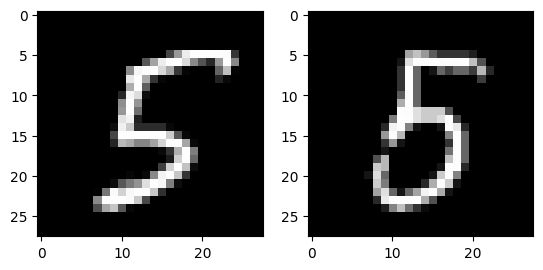

In [5]:
# Find two images from the same class and plot them

# give the class that we want to construct one mixed image on
same_class = 5
two_same_image = []

for img_idx in range(16, 120):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    if label == same_class:
        two_same_image.append(img_idx)
    if len(two_same_image) == 2:
        break
        
assert len(two_same_image) == 2, "Need 2 samples!"
        
print(f"Two same class images from class {same_class} we found: {two_same_image}")

two_same_cls_imgs = torch.utils.data.Subset(dataset2, two_same_image)
(same_cls_img1, same_cls_label1) =  two_same_cls_imgs[0]
(same_cls_img2, same_cls_label2) =  two_same_cls_imgs[1]

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(same_cls_img1.reshape(28, 28), cmap="gray")
axarr[1].imshow(same_cls_img2.reshape(28, 28), cmap="gray")
plt.show()
plt.close(f)


### Mixing process

alphas picked:  [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]


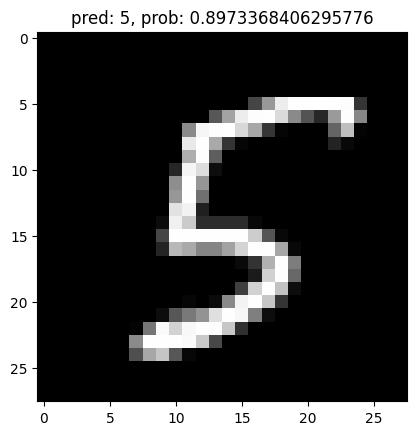

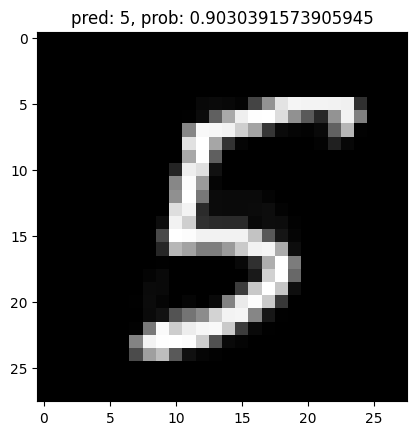

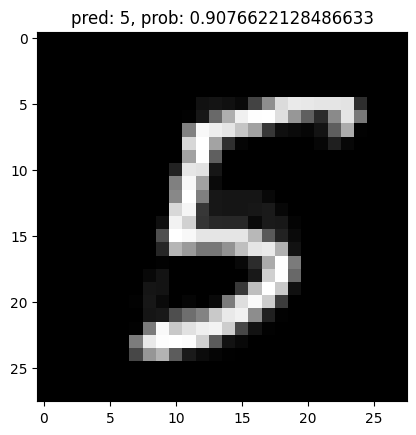

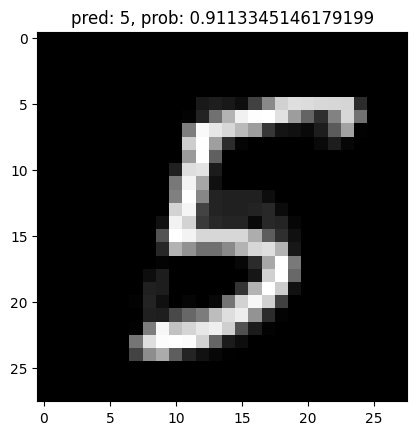

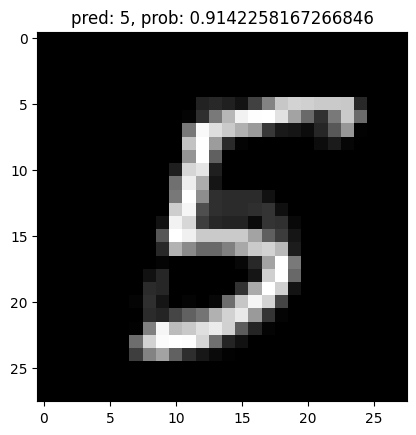

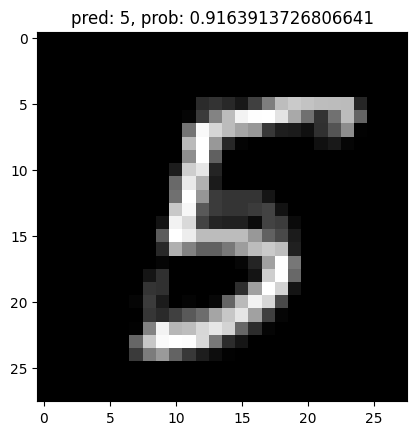

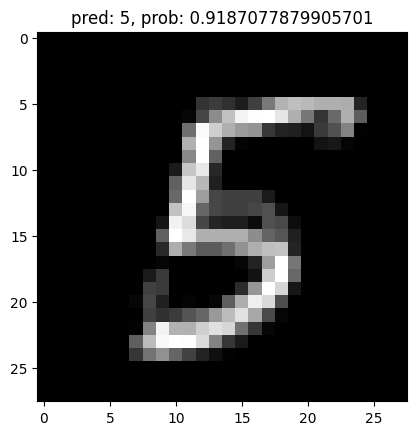

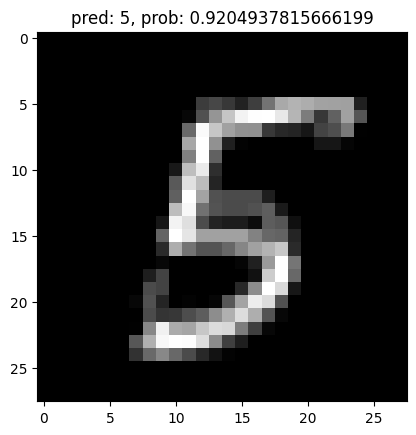

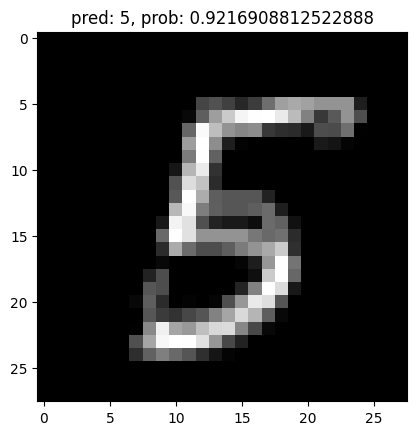

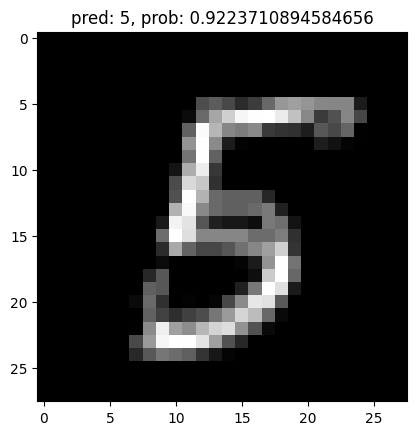

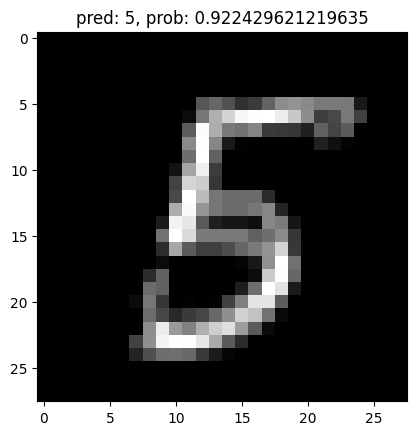

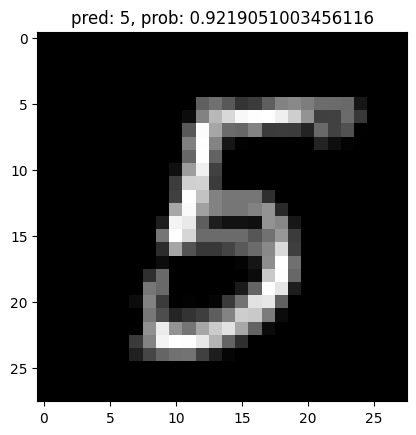

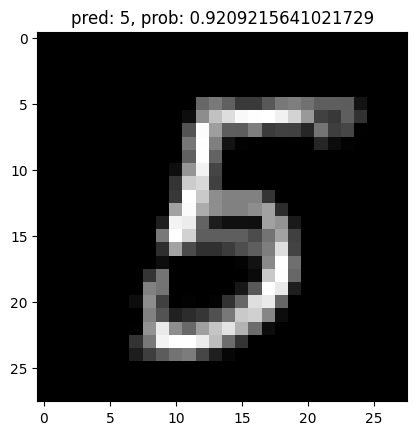

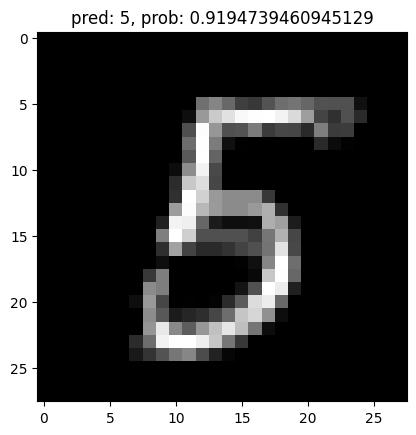

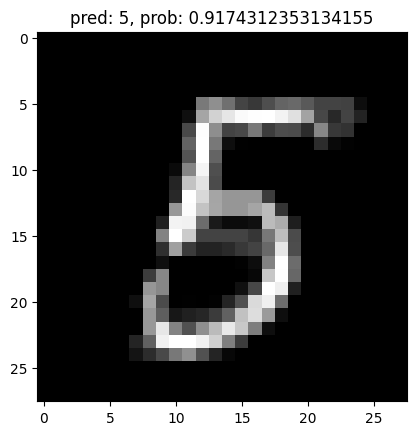

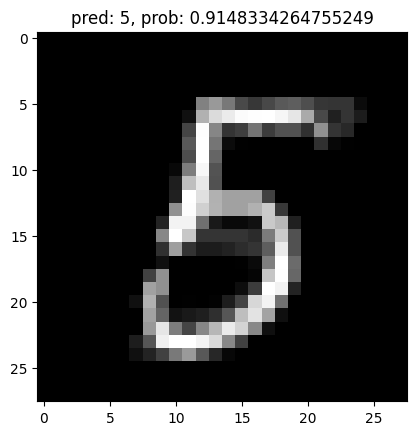

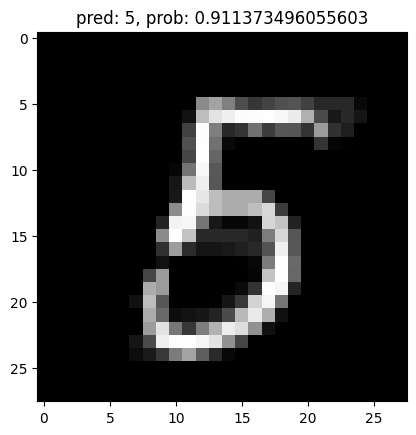

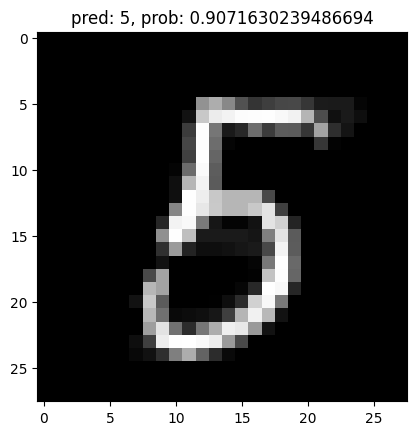

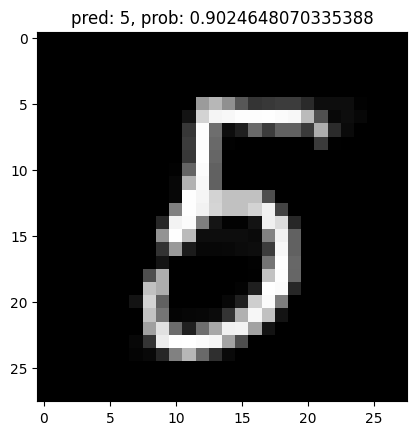

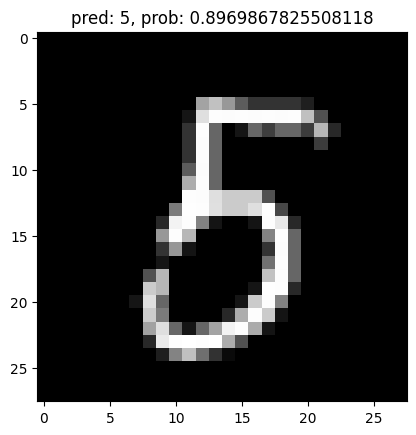

In [6]:
# Sample the alpha values, and draw the mixed images

# Number of alpha values we pick along the mixing prcess
num_sample = 20

alps = np.linspace(0, 1, num_sample)
alps = np.sort(alps) 
print("alphas picked: ", alps)


if not os.path.exists(TMP_MIX_IMG_FOLDER):
    os.mkdir(TMP_MIX_IMG_FOLDER)
if not os.path.exists(MIX_GIF_FOLDER):
    os.mkdir(MIX_GIF_FOLDER)
if not os.path.exists(MIX_GRAPH):
    os.mkdir(MIX_GRAPH)

mixed_img_names = []
# mixed_img_cls_prod = []
all_mixed_imgs = []
all_cls_probs = []

for i in range(len(alps)):
    a = alps[i]
    mixed_img = (1-a)*same_cls_img1 + a*same_cls_img2
    mixed_img_extend = mixed_img[None, :]
    
    
    # make the prediction of all the mixed images with different alpha values
    with torch.no_grad():
        output = model(mixed_img_extend.to(device))
    prob_output =  torch.softmax(output, dim=1)
    all_cls_probs.append(prob_output)
    pred_prob = torch.max(prob_output)
    pred = torch.argmax(output).item()
    
    
    figure = plt.figure()
    plt.imshow(mixed_img.reshape(28, 28), cmap="gray")
    plt.title(f"pred: {pred}, prob: {pred_prob}")
    mix_img_name = f"mix{two_same_image[0]}-{two_same_image[1]}_{i}.png"
    mixed_img_names.append(mix_img_name)
    plt.savefig(os.path.join(TMP_MIX_IMG_FOLDER, mix_img_name))
    
# the probabilities of all the classes for all the predictions
all_cls_probs_tensor = torch.cat(all_cls_probs)  
    

# generate gif
generate_gif(os.path.join(MIX_GIF_FOLDER, GIF_RESULT.format(two_same_image[0], two_same_image[1])), TMP_MIX_IMG_FOLDER, mixed_img_names, True)





### Plot the prediction

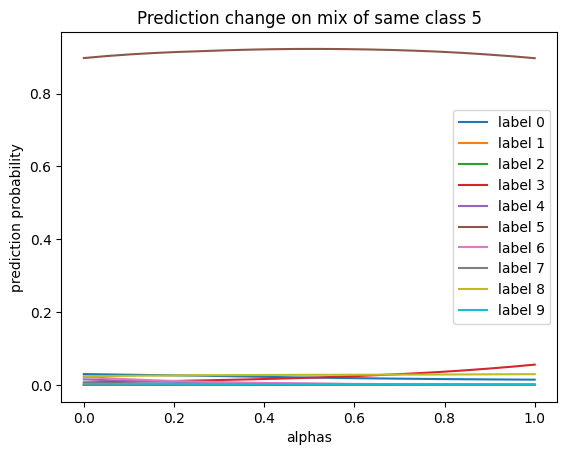

In [7]:
# all_cls_probs_tensor.cpu()
for c in range(10):
    plt.plot(alps, all_cls_probs_tensor.cpu()[:, c], label=f"label {c}")
plt.xlabel('alphas')
plt.ylabel('prediction probability')

plt.title(f'Prediction change on mix of same class {same_class}')
plt.legend()
graph_name =  f"graphmix{two_same_image[0]}-{two_same_image[1]}.png"
plt.savefig(os.path.join(MIX_GRAPH, graph_name))
plt.show()
plt.close()

## Two images from different classes

Two same class images from class 5 we found: [23, 45]


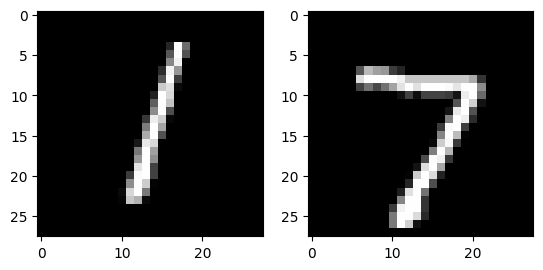

In [8]:
# Find two images from the same class

diff_class = {1: None, 7: None}

# Find the images from the two classes given above, not randomly though
for img_idx in range(0, 120):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]
    if label in list(diff_class.keys()) and diff_class[label] is None:
        diff_class[label]= img_idx
    if None not in list(diff_class.values()):
        break

# Just to check to make sure two images are found        
assert len(diff_class) == 2, "Need 2 samples!"
        
print(f"Two same class images from class {same_class} we found: {two_same_image}")

two_diff_cls_imgs = torch.utils.data.Subset(dataset2, list(diff_class.values()))
(diff_cls_img1, diff_cls_label1) =  two_diff_cls_imgs[0]
(diff_cls_img2, diff_cls_label2) =  two_diff_cls_imgs[1]

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(diff_cls_img1.reshape(28, 28), cmap="gray")
axarr[1].imshow(diff_cls_img2.reshape(28, 28), cmap="gray")
plt.show()
plt.close(f)

alphas picked:  [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]


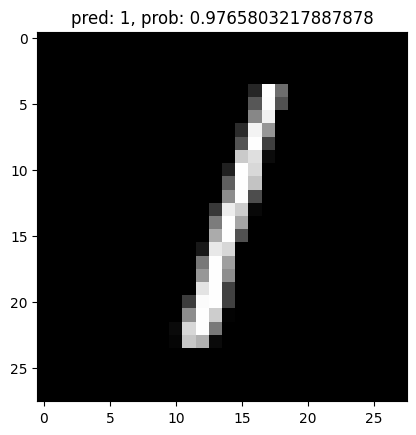

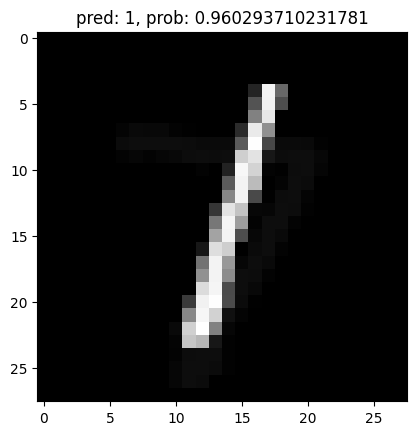

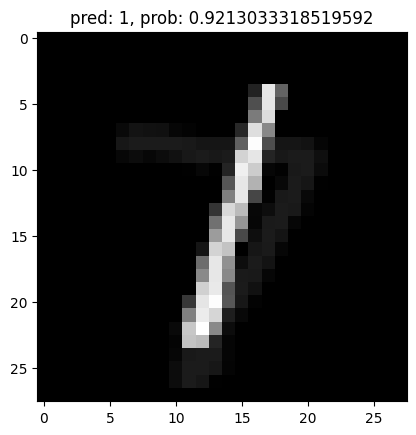

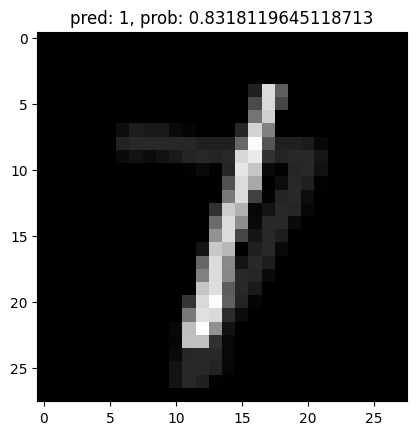

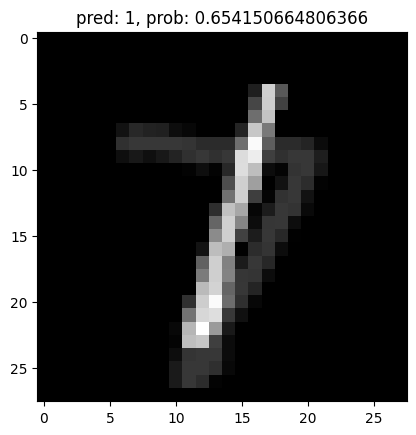

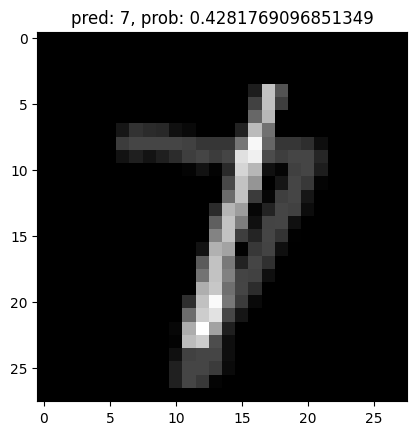

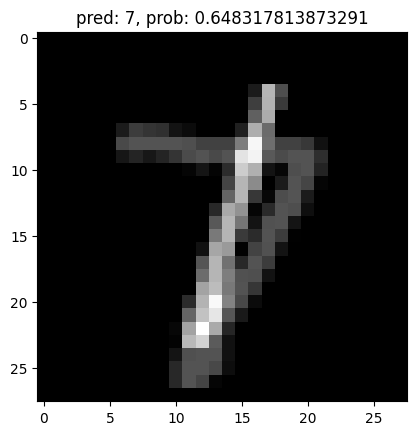

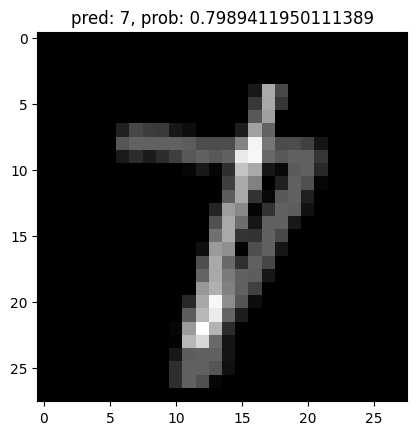

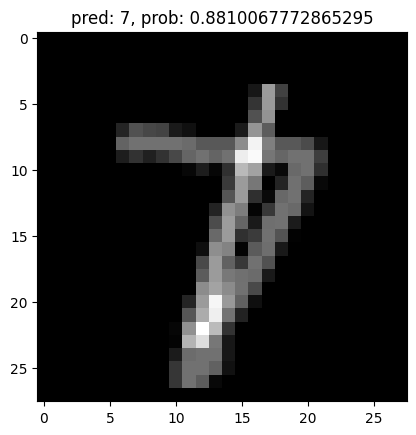

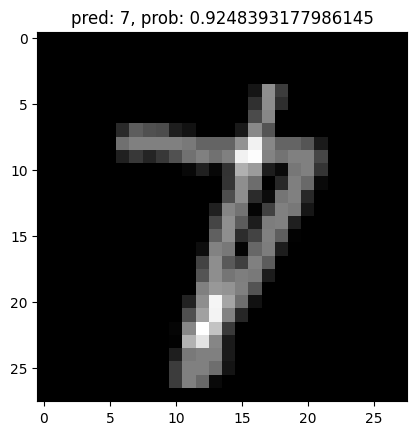

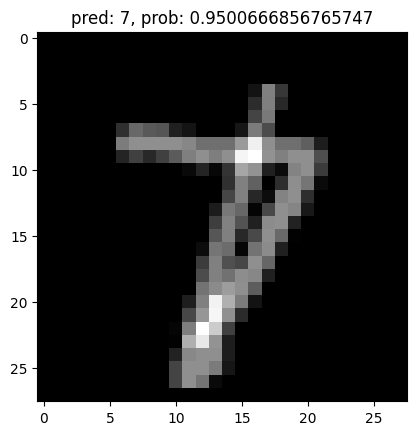

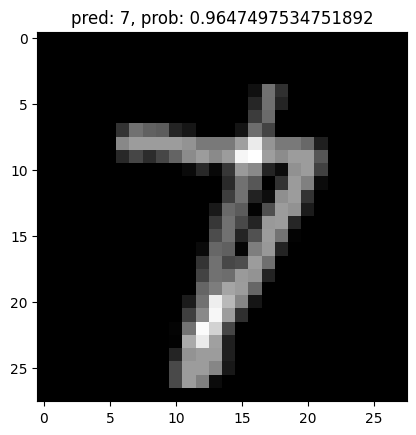

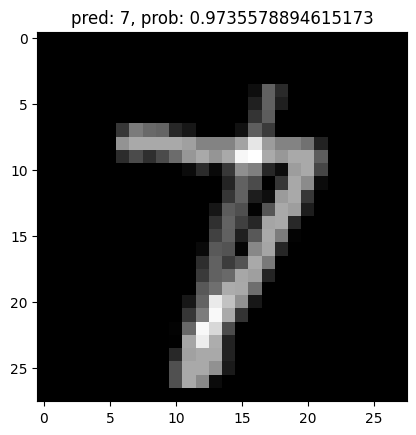

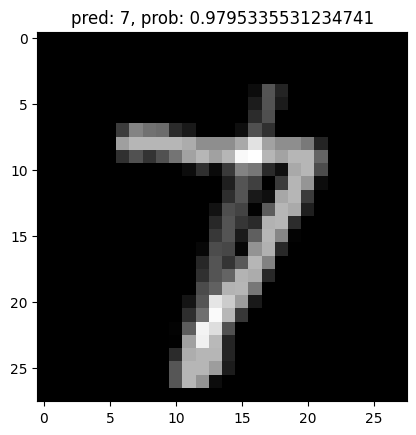

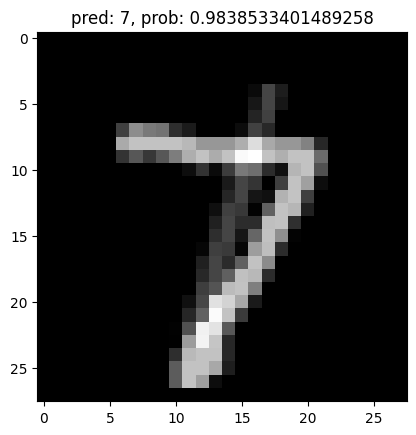

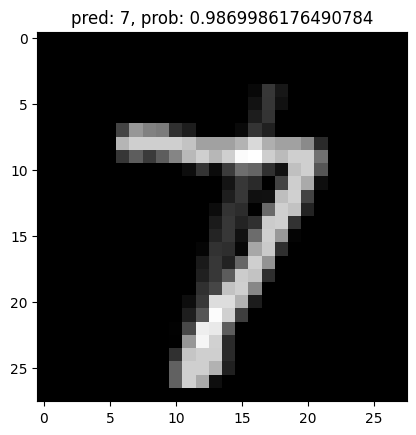

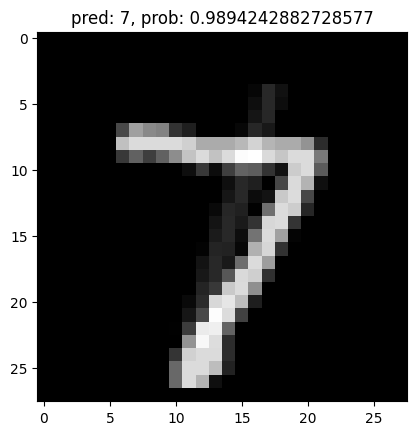

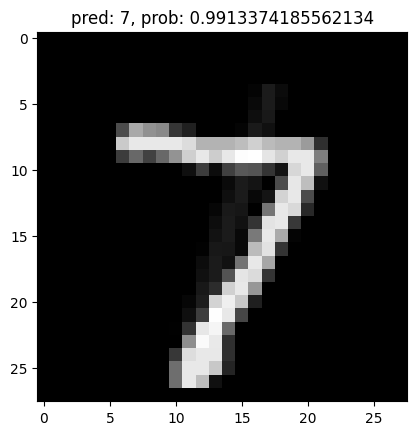

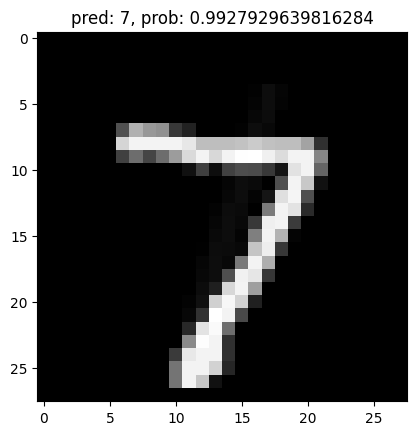

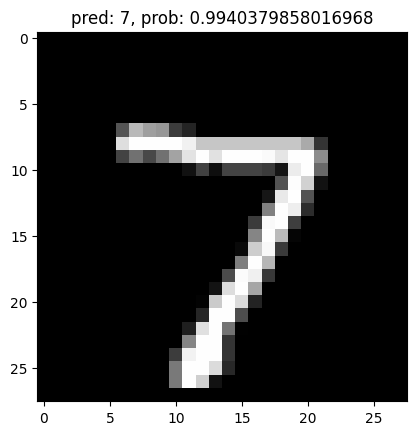

In [9]:
#Sample the alpha values, and draw the mixed images

num_sample = 20
alps = np.linspace(0, 1, num_sample)
alps = np.sort(alps) 
print("alphas picked: ", alps)


if not os.path.exists(TMP_MIX_IMG_FOLDER):
    os.mkdir(TMP_MIX_IMG_FOLDER)
if not os.path.exists(MIX_GIF_FOLDER):
    os.mkdir(MIX_GIF_FOLDER)
if not os.path.exists(MIX_GRAPH):
    os.mkdir(MIX_GRAPH)

mixed_img_names = []
# mixed_img_cls_prod = []
all_mixed_imgs = []
all_cls_probs = []

for i in range(len(alps)):
    a = alps[i]
    mixed_img = (1-a)*diff_cls_img1 + a*diff_cls_img2
#     print(mixed_img.size())
    mixed_img_extend = mixed_img[None, :]
    
    
    # make the prediction
    with torch.no_grad():
        output = model(mixed_img_extend.to(device))
    prob_output =  torch.softmax(output, dim=1)
    all_cls_probs.append(prob_output)
    pred_prob = torch.max(prob_output)
    pred = torch.argmax(output).item()
    
    
    figure = plt.figure()
    plt.imshow(mixed_img.reshape(28, 28), cmap="gray")
    plt.title(f"pred: {pred}, prob: {pred_prob}")
    mix_img_name = f"mix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}_{i}.png"
    mixed_img_names.append(mix_img_name)
    plt.savefig(os.path.join(TMP_MIX_IMG_FOLDER, mix_img_name))
    plt.show()
    plt.close(figure)
    

all_cls_probs_tensor = torch.cat(all_cls_probs)  
    

# generate gif
generate_gif(os.path.join(MIX_GIF_FOLDER, GIF_RESULT.format(list(diff_class.values())[0], list(diff_class.values())[1])), TMP_MIX_IMG_FOLDER, mixed_img_names, True)





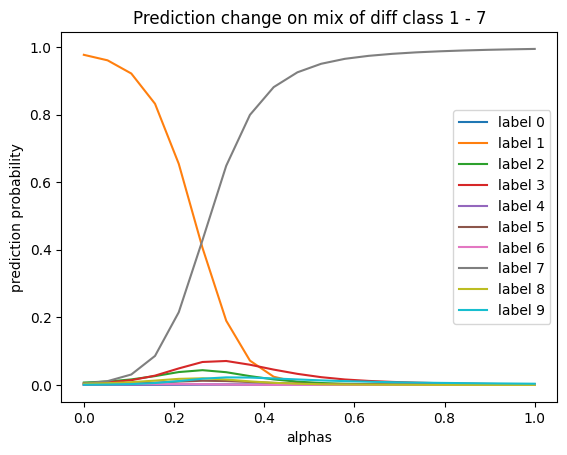

In [10]:
for c in range(10):
    plt.plot(alps, all_cls_probs_tensor.cpu()[:, c], label=f"label {c}")
plt.xlabel('alphas')
plt.ylabel('prediction probability')

plt.title(f'Prediction change on mix of diff class {list(diff_class.keys())[0]} - {list(diff_class.keys())[1]}')
plt.legend()
graph_name = f"graphmix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}.png"
plt.savefig(os.path.join(MIX_GRAPH, graph_name))
plt.show()
plt.close()

## Mix some image with an all black image, i.e. adjust the lightness of some image from all black to original

$I_{mix} = \alpha I$ where $\alpha$ goes from $0 \to 1$

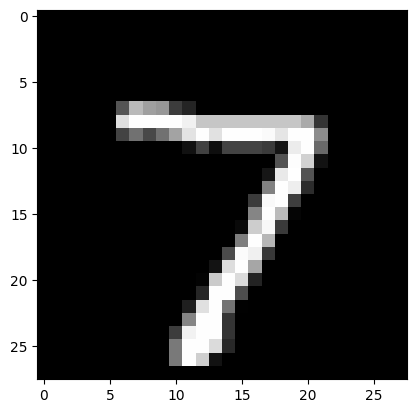

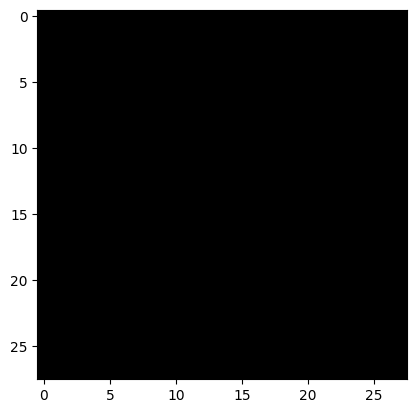

In [15]:

# give the idx of the image we want to do the mixing
img_idx = 0
(img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]


new = img * 0


figure = plt.figure()
plt.imshow(img.reshape(28, 28), cmap="gray")
plt.show()
plt.close(figure)

figure = plt.figure()
plt.imshow(new.reshape(28, 28), cmap="gray")
plt.show()
plt.close(figure)

(diff_cls_img1, diff_cls_label1) =  new, label
(diff_cls_img2, diff_cls_label2) =  img, label

alphas picked:  [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]


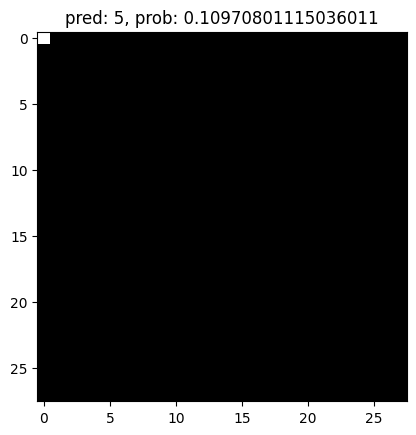

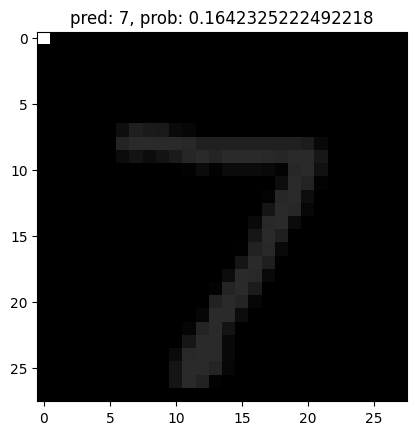

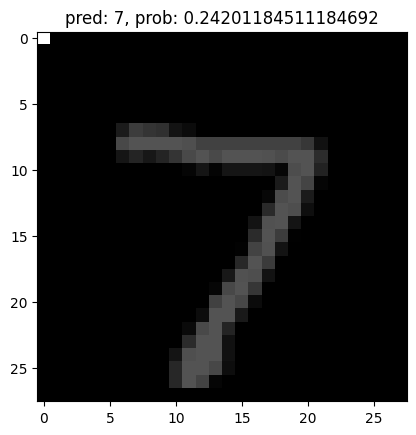

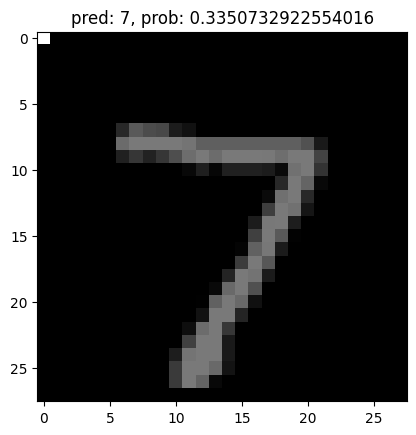

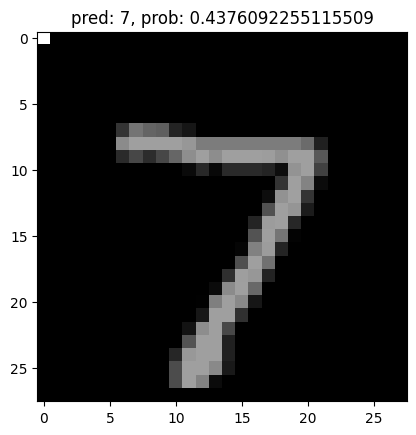

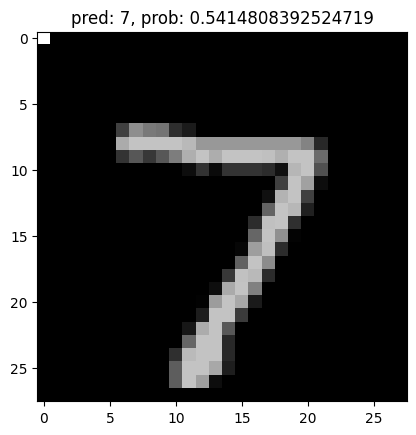

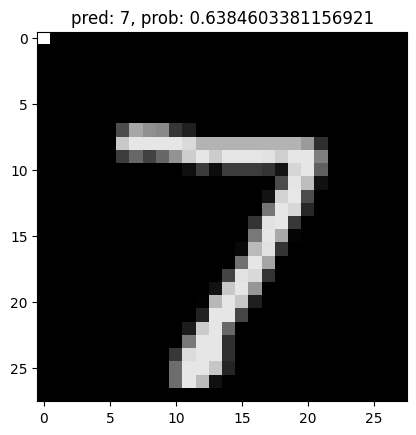

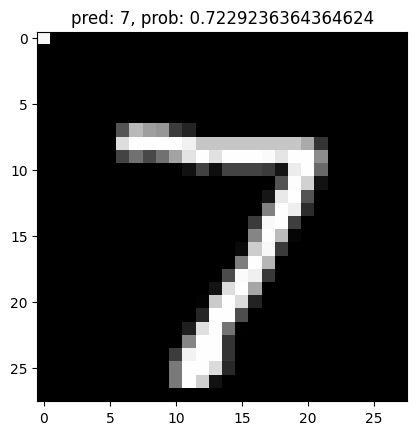

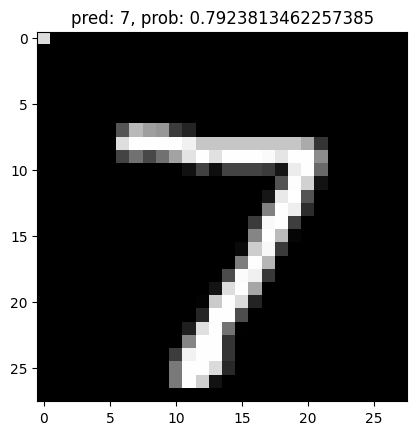

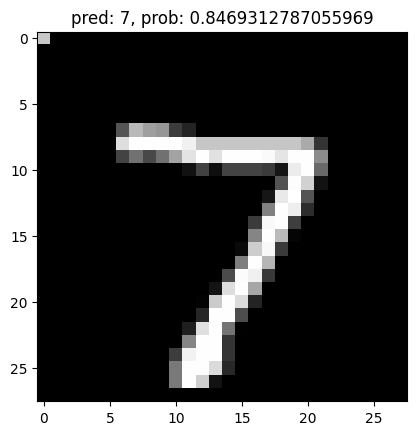

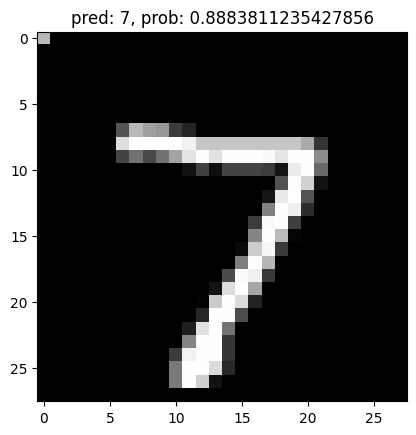

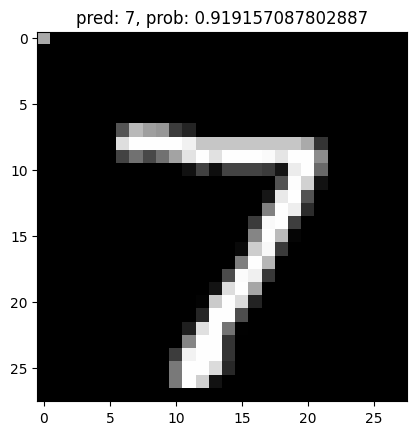

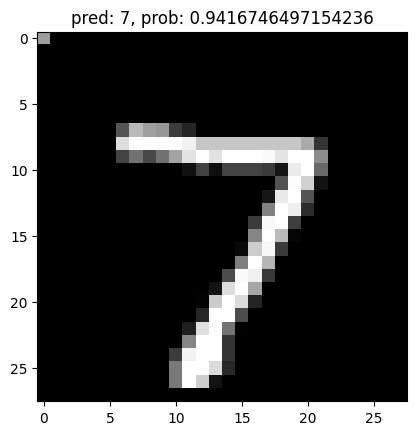

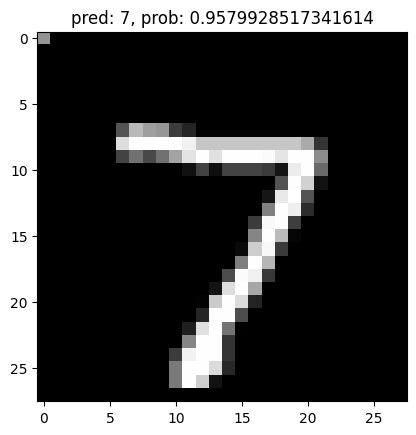

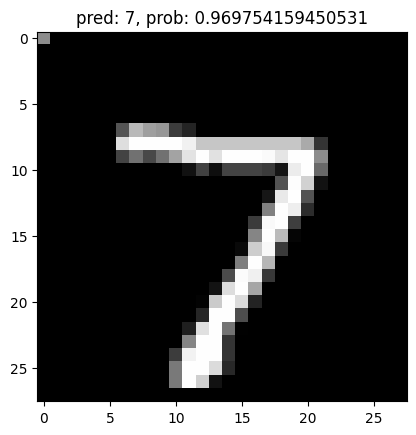

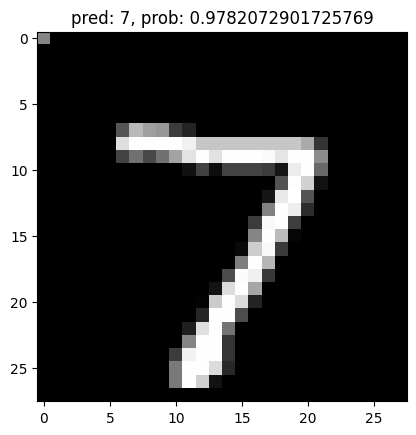

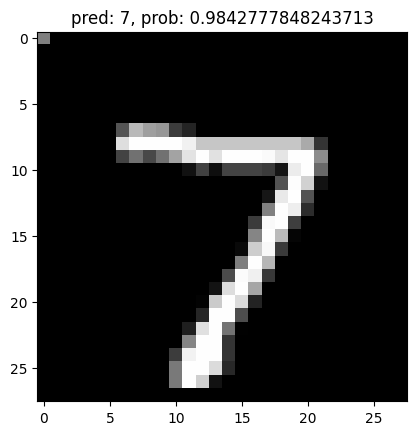

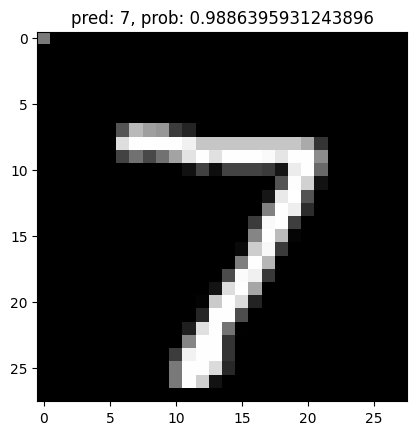

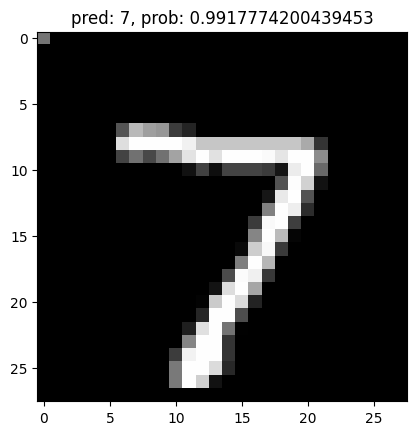

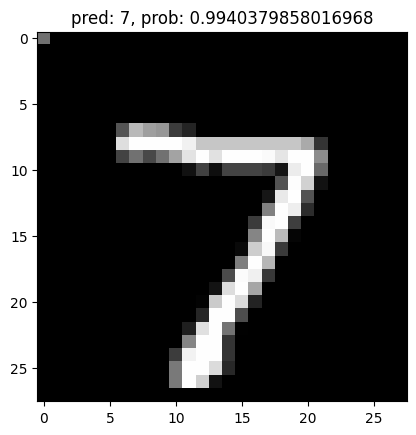

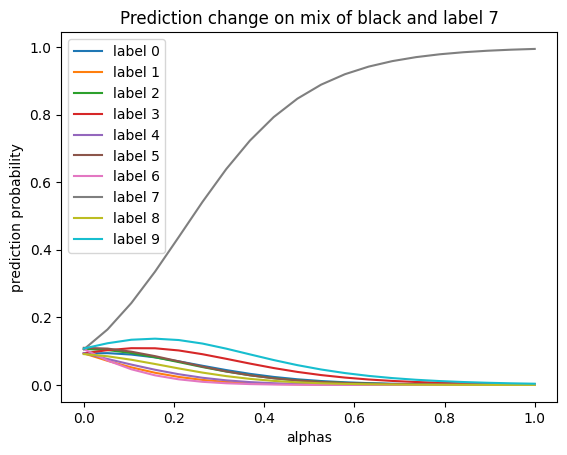

In [16]:
#Sample the alpha values, and draw the mixed images

num_sample = 20
alps = np.linspace(0, 1, num_sample)
alps = np.sort(alps) 
print("alphas picked: ", alps)


if not os.path.exists(TMP_MIX_IMG_FOLDER):
    os.mkdir(TMP_MIX_IMG_FOLDER)
if not os.path.exists(MIX_GIF_FOLDER):
    os.mkdir(MIX_GIF_FOLDER)
if not os.path.exists(MIX_GRAPH):
    os.mkdir(MIX_GRAPH)

mixed_img_names = []
# mixed_img_cls_prod = []
all_mixed_imgs = []
all_cls_probs = []

for i in range(len(alps)):
    a = alps[i]
    mixed_img = (1-a)*diff_cls_img1 + a*diff_cls_img2
#     print("image value: ", mixed_img)
#     print(f"a is {a}")
#     print("max: ", torch.max(mixed_img.reshape(28* 28), axis = 0))
#     print()
#     print("min: ", torch.min(mixed_img.reshape(28* 28), axis = 0))
#     print()
#     print("mean: ", torch.mean(mixed_img.reshape(28* 28), axis = 0))
#     print()
#     print("max: ", np.max(mixed_img, axis = 0))
#     print(mixed_img.size())
    mixed_img_extend = mixed_img[None, :]
    
    
    # make the prediction
    with torch.no_grad():
        output = model(mixed_img_extend.to(device))
    prob_output =  torch.softmax(output, dim=1)
    all_cls_probs.append(prob_output)
    pred_prob = torch.max(prob_output)
    pred = torch.argmax(output).item()
    
    
    figure = plt.figure()
    mixed_img[..., 0, 0] = 1.0 
    plt.imshow(mixed_img.reshape(28, 28), cmap="gray")
    plt.title(f"pred: {pred}, prob: {pred_prob}")
#     mix_img_name = f"mix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}_{i}.png"
#     mixed_img_names.append(mix_img_name)
#     plt.savefig(os.path.join(TMP_MIX_IMG_FOLDER, mix_img_name))
    plt.show()
    plt.close(figure)

all_cls_probs_tensor = torch.cat(all_cls_probs)  
    

# generate gif
# generate_gif(os.path.join(MIX_GIF_FOLDER, GIF_RESULT.format(list(diff_class.values())[0], list(diff_class.values())[1])), TMP_MIX_IMG_FOLDER, mixed_img_names, True)

# all_cls_probs_tensor.cpu()
figure = plt.figure()
for c in range(10):
    plt.plot(alps, all_cls_probs_tensor.cpu()[:, c], label=f"label {c}")
plt.xlabel('alphas')
plt.ylabel('prediction probability')
plt.title(f'Prediction change on mix of black and label {label}')
plt.legend()
# function to show the plot
# graph_name = f"graphmix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}.png"
# plt.savefig(os.path.join(MIX_GRAPH, graph_name))
plt.show()
plt.close(figure)

## Mix between some adversial attacked (by fast gradient method) image with an all black image.

find adversial example: 50 with label 6 and attack pred tensor([0])


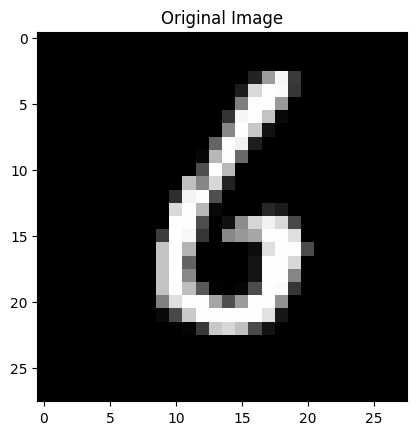

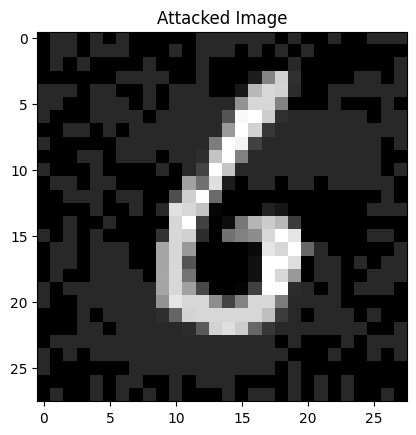

In [18]:
# Find an image that can be sucessfully attacked
for img_idx in range(50, 100):
    (img, label) = torch.utils.data.Subset(dataset2, [img_idx])[0]

    x_extend = img[None, :]

    x_extend = x_extend.to(device)
    x_fgm = fast_gradient_method(model, x_extend, 0.3, np.inf)
    _, y_pred_fgm = model(x_fgm).max(
                1
            )
    if y_pred_fgm != label:
        print(f"find adversial example: {img_idx} with label {label} and attack pred {y_pred_fgm}")
        break


figure = plt.figure()
plt.imshow(img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
plt.title('Original Image')
plt.show()
plt.close(figure)

figure = plt.figure()
plt.imshow(x_fgm.cpu().detach().numpy().reshape(28, 28), cmap="gray")
plt.title('Attacked Image')
plt.show()
plt.close(figure)

(diff_cls_img1, diff_cls_label1) =  x_extend*0, label
(diff_cls_img2, diff_cls_label2) =  x_fgm, label

alphas picked:  [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]


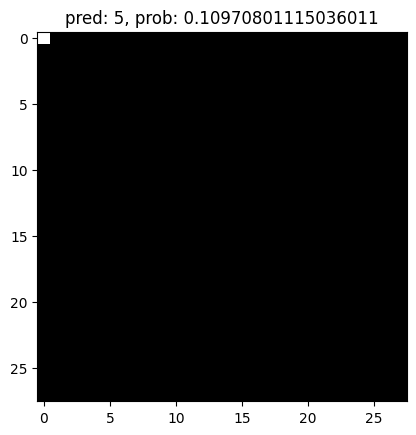

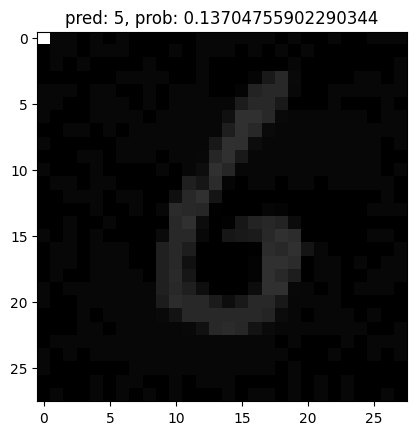

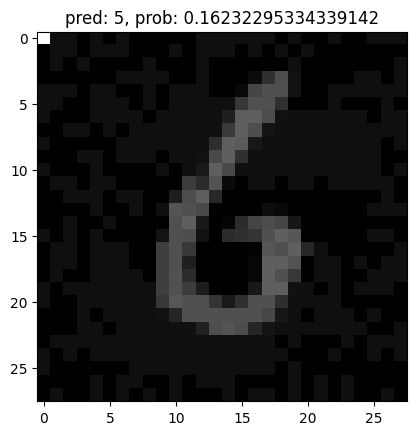

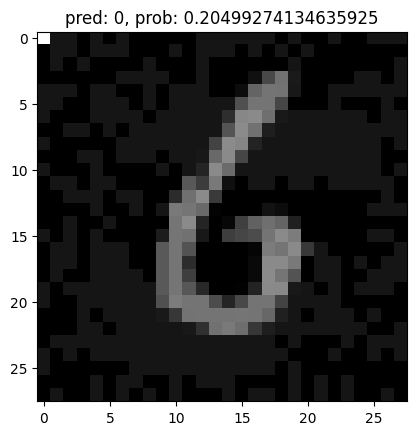

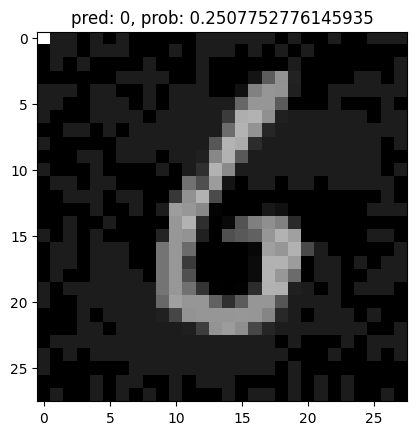

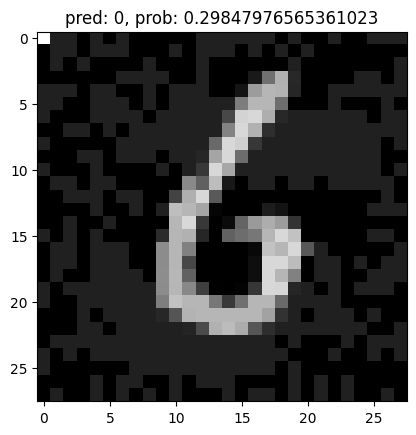

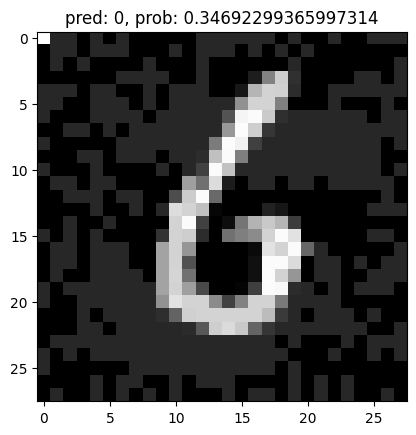

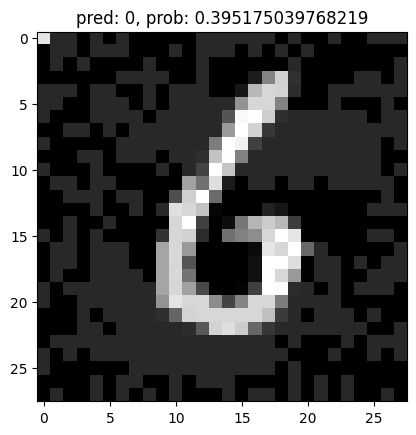

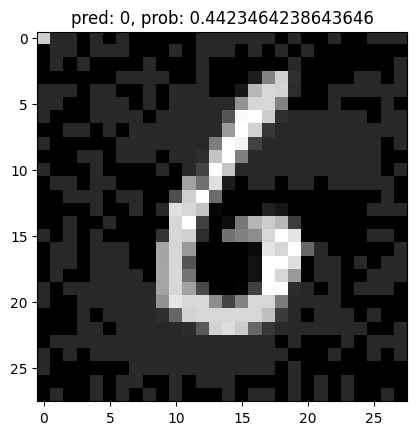

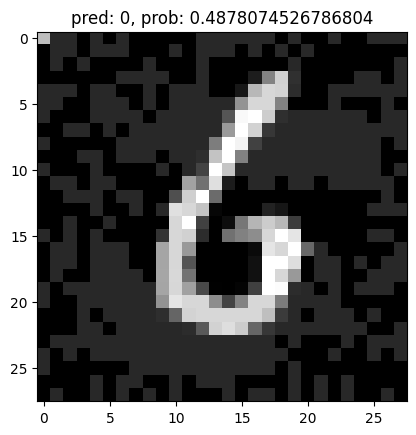

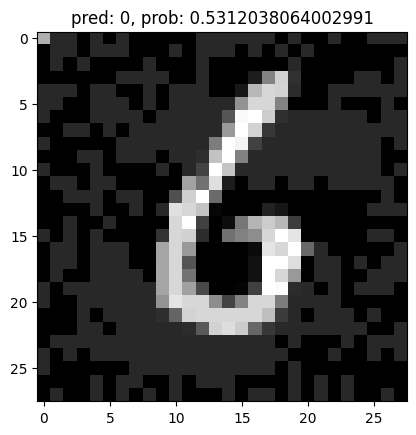

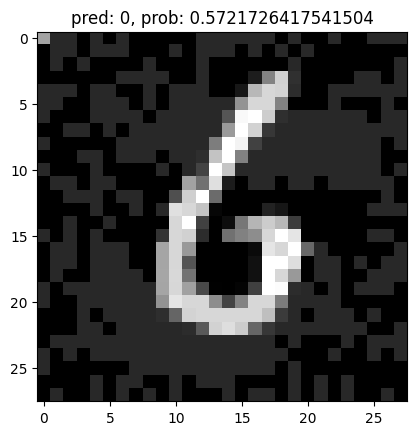

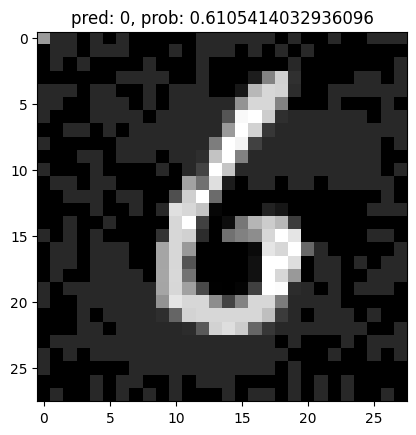

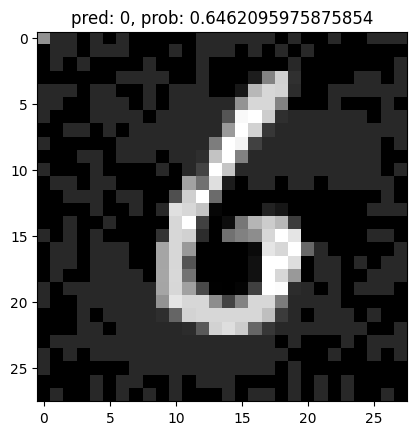

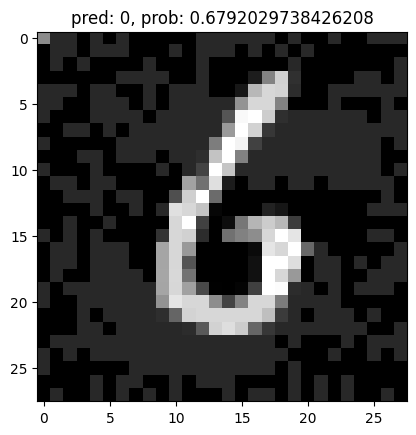

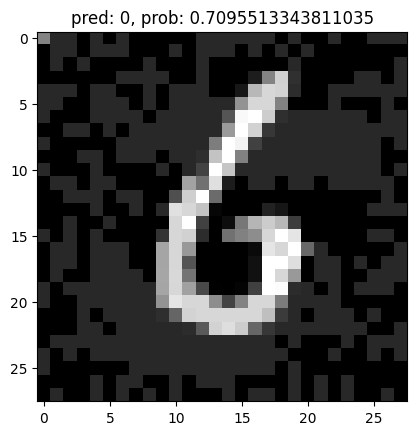

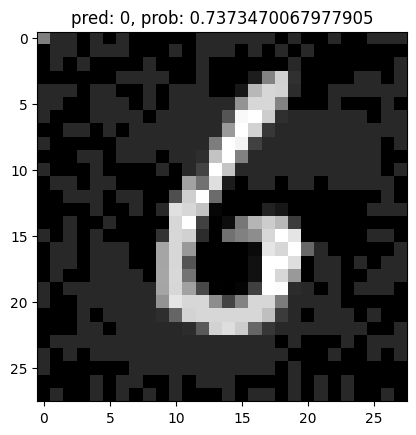

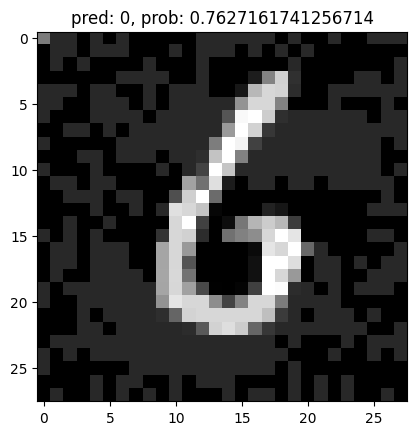

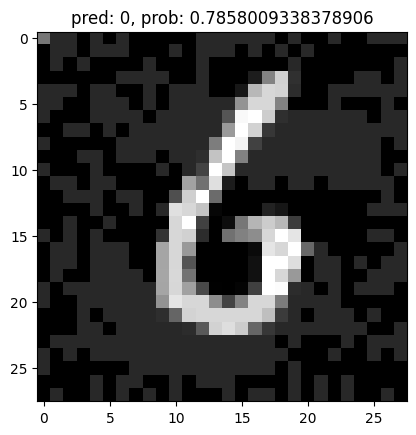

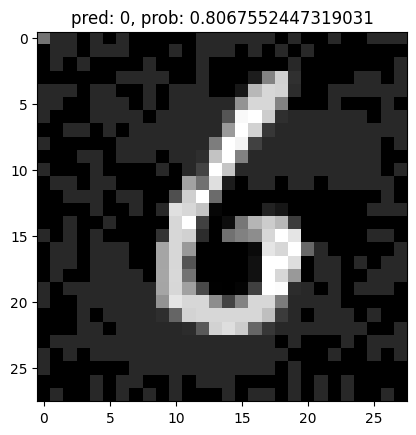

tensor([0.0929, 0.1234, 0.1621, 0.2050, 0.2508, 0.2985, 0.3469, 0.3952, 0.4423,
        0.4878, 0.5312, 0.5722, 0.6105, 0.6462, 0.6792, 0.7096, 0.7373, 0.7627,
        0.7858, 0.8068])


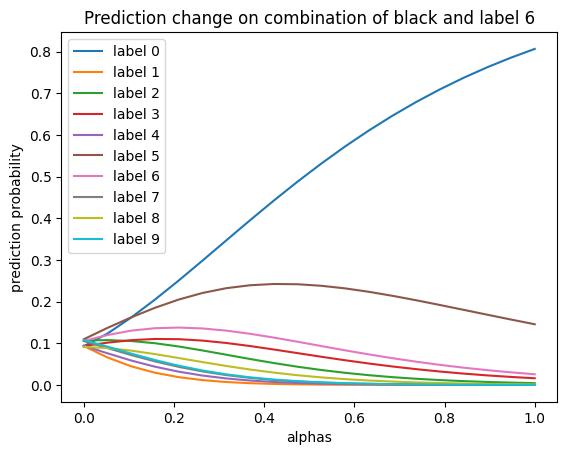

In [19]:
#Sample the alpha values, and draw the mixed images

num_sample = 20
# alps = np.random.uniform(low=0.0, high=1.0, size=num_sample)
alps = np.linspace(0, 1, num_sample)
alps = np.sort(alps) 
print("alphas picked: ", alps)


if not os.path.exists(TMP_MIX_IMG_FOLDER):
    os.mkdir(TMP_MIX_IMG_FOLDER)
if not os.path.exists(MIX_GIF_FOLDER):
    os.mkdir(MIX_GIF_FOLDER)
if not os.path.exists(MIX_GRAPH):
    os.mkdir(MIX_GRAPH)

mixed_img_names = []
# mixed_img_cls_prod = []
all_mixed_imgs = []
all_cls_probs = []

for i in range(len(alps)):
    a = alps[i]
    mixed_img = (1-a)*diff_cls_img1 + a*diff_cls_img2
    mixed_img_extend = mixed_img

#     print("image value: ", mixed_img)
#     print(f"a is {a}")
#     print("max: ", torch.max(mixed_img.reshape(28* 28), axis = 0))
#     print()
#     print("min: ", torch.min(mixed_img.reshape(28* 28), axis = 0))
#     print()
#     print("mean: ", torch.mean(mixed_img.reshape(28* 28), axis = 0))
#     print()
#     print("max: ", np.max(mixed_img, axis = 0))
#     print("check size:", mixed_img.size())
    
    
    # make the prediction
    with torch.no_grad():
        output = model(mixed_img_extend.to(device))
    prob_output =  torch.softmax(output, dim=1)
    all_cls_probs.append(prob_output)
    pred_prob = torch.max(prob_output)
    pred = torch.argmax(output).item()
    
    
    figure = plt.figure()
    mixed_img[..., 0, 0] = 1.0 
    plt.imshow(mixed_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    plt.title(f"pred: {pred}, prob: {pred_prob}")
#     mix_img_name = f"mix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}_{i}.png"
#     mixed_img_names.append(mix_img_name)
#     plt.savefig(os.path.join(TMP_MIX_IMG_FOLDER, mix_img_name))
    plt.show()
    plt.close(figure)
    

all_cls_probs_tensor = torch.cat(all_cls_probs)  
print(all_cls_probs_tensor[:, 0])
    

# generate gif
# generate_gif(os.path.join(MIX_GIF_FOLDER, GIF_RESULT.format(list(diff_class.values())[0], list(diff_class.values())[1])), TMP_MIX_IMG_FOLDER, mixed_img_names, True)

# all_cls_probs_tensor.cpu()
figure = plt.figure()
for c in range(10):
    # plotting the points 
    plt.plot(alps, all_cls_probs_tensor.cpu()[:, c], label=f"label {c}")
plt.xlabel('alphas')
plt.ylabel('prediction probability')
plt.title(f'Prediction change on combination of black and label {label}')
plt.legend()
# function to show the plot
# graph_name = f"graphmix{list(diff_class.values())[0]}-{list(diff_class.values())[1]}.png"
# plt.savefig(os.path.join(MIX_GRAPH, graph_name))
plt.show()
plt.close(figure)